In [5]:
import skimage
import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import time
import argparse
import cv2
from scipy import io
from tqdm.notebook import tqdm

import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler
# from pytorch_msssim import ssim

import utils
#from modules.models import INR

In [97]:
parser = argparse.ArgumentParser(description='kan')

# Shared Parameters
parser.add_argument('--input',type=str, default='/home/moein/Lstm-mam/KATS-Net/Kodak/kodim03.png', help='Input image path')
parser.add_argument('--inr_model',type=str, default='kan', help='[gauss, mfn, relu, siren, wire, wire2d, ffn, incode]')
parser.add_argument('--lr',type=float, default=1e-4, help='Learning rate')
parser.add_argument('--using_schedular', type=bool, default=True, help='Whether to use schedular')
parser.add_argument('--scheduler_b', type=float, default=0.1, help='Learning rate scheduler')
parser.add_argument('--maxpoints', type=int, default=64*64, help='Batch size')
parser.add_argument('--niters', type=int, default=501, help='Number if iterations')
parser.add_argument('--steps_til_summary', type=int, default=100, help='Number of steps till summary visualization')


parser.add_argument('--a_coef',type=float, default=0.1993, help='a coeficient')
parser.add_argument('--b_coef',type=float, default=0.0196, help='b coeficient')
parser.add_argument('--c_coef',type=float, default=0.0588, help='c coeficient')
parser.add_argument('--d_coef',type=float, default=0.0269, help='d coeficient')


args = parser.parse_args(args=[])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Loading Data

In [7]:
im = utils.normalize(plt.imread(args.input).astype(np.float32), True)
# im = cv2.resize(im, None, fx=1/4, fy=1/4, interpolation=cv2.INTER_AREA)
H, W, _ = im.shape
# image = cv2.resize(im, (512, 512))

(512, 768, 3)


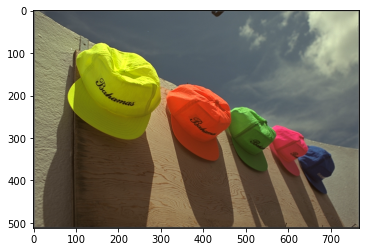

In [8]:
plt.imshow(im)
print(im.shape)

WE SHOULD ADD BERN HERE ALI JAN

In [9]:
import torch
import torch.nn as nn
import math as m

# This is inspired by Kolmogorov-Arnold Networks but using Chebyshev polynomials instead of splines coefficients
class FourierKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, gridsize,addbias=True,smooth_initialization=False):
        super(FourierKANLayer, self).__init__()
        self.gridsize= gridsize
        self.addbias = addbias
        self.inputdim = input_dim
        self.outdim = output_dim


        grid_norm_factor = (torch.arange(gridsize) + 1)**2 if smooth_initialization else np.sqrt(gridsize)

        #The normalization has been chosen so that if given inputs where each coordinate is of unit variance,
        #then each coordinates of the output is of unit variance
        #independently of the various sizes
        self.fouriercoeffs = torch.nn.Parameter( torch.randn(2,output_dim,input_dim,gridsize) /
                                                (np.sqrt(input_dim) * grid_norm_factor ) )

        if( self.addbias ):
            self.bias  = torch.nn.Parameter( torch.zeros(1,output_dim))

    def forward(self, x):

        xshp = x.shape
        
        outshape = xshp[0:-1]+(self.outdim,)
        x = torch.reshape(x,(-1,self.inputdim))
        

        #Starting at 1 because constant terms are in the bias
        k = torch.reshape( torch.arange(1,self.gridsize+1,device=x.device),(1,1,1,self.gridsize))
        
        xrshp = torch.reshape(x,(x.shape[0],1,x.shape[1],1) )
        
        #This should be fused to avoid materializing memory
        c = torch.cos( k*xrshp )
        s = torch.sin( k*xrshp )
        
        #We compute the interpolation of the various functions defined by their fourier coefficient for each input coordinates and we sum them
        y =  torch.sum( c*self.fouriercoeffs[0:1],(-2,-1))
        y += torch.sum( s*self.fouriercoeffs[1:2],(-2,-1))
        if( self.addbias):
            y += self.bias
        #End fuse


        y = torch.reshape( y, outshape)
        return y




In [100]:
class SineLayer(nn.Module):
    '''
    SineLayer is a custom PyTorch module that applies the Sinusoidal activation function to the output of a linear transformation.

    Args:
        in_features (int): Number of input features.
        out_features (int): Number of output features.
        bias (bool, optional): If True, the linear transformation includes a bias term. Default is True.
        is_first (bool, optional): If it is the first layer, we initialize the weights differently. Default is False.
        omega_0 (float, optional): Frequency scaling factor for the sinusoidal activation. Default is 30.
        scale (float, optional): Scaling factor for the output of the sine activation. Default is 10.0.
        init_weights (bool, optional): If True, initializes the layer's weights according to the SIREN paper. Default is True.

    '''
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30, scale=10.0,init_weights=True):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        #self.grid=grid
        self.in_features = in_features
        self.a=nn.Parameter(torch.tensor(1.))
        self.b=nn.Parameter(torch.tensor(30.))
        self.c=nn.Parameter(torch.tensor(1.))
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        #k = torch.reshape( torch.arange(1,grid+1),(1,1,1,self.gridsize))
        
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        #k = torch.reshape( torch.arange(1,self.grid+1,device=input.device),(1,1,self.grid))

        #a=self.linear(input)
        #a=a[:,:,None]

        #print(a.shape)

        #s = torch.sin( k*a )

        #return torch.tanh(self.omega_0 *self.linear(input))
        #######################################################################

        #return (self.linear(input)+torch.sin(self.omega_0 *self.linear(input)))*nn.Sigmoid()(self.linear(input))


        #y=self.linear(input)
    ################################################################################
        return (self.linear(input)+torch.tanh(self.omega_0*self.linear(input)))*nn.Sigmoid()(self.linear(input))
    
        ####return (self.linear(input)+torch.tanh(self.b*self.linear(input)))*nn.Sigmoid()(self.linear(input))
        #return (torch.tanh(self.omega_0*self.linear(input)))
        ####return (torch.tanh(self.b*self.linear(input)))

        #return (self.a*torch.exp(-self.b*self.linear(input)*self.linear(input)))*torch.tanh(self.omega_0*self.linear(input))

        #return (self.linear(input)+torch.tanh(self.omega_0*self.linear(input))+torch.sin(self.omega_0*self.linear(input)))*nn.Sigmoid()(self.linear(input))
    
    

        #return self.linear(input)*torch.tanh(torch.exp(self.omega_0*self.linear(input)))


        #return torch.sum(torch.sin( k*a )+torch.cos( k*a ),-1)

In [137]:
class FKANLayer(nn.Module):
    def __init__(self, in_features, out_features, grid):
        super(FKANLayer, self).__init__()
        self.fkan = FourierKANLayer(in_features, out_features, grid)
        self.norm = nn.LayerNorm(out_features)

    def forward(self, x):
        x = self.fkan(x)
        x = self.norm(x)
        return x

class ReLULayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(ReLULayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=bias)

    def forward(self, input):
        return nn.functional.relu(self.linear(input))



class FKAN_INR(nn.Module):
    def __init__(self, in_features, hidden_features, out_features,grid):
        super(FKAN_INR, self).__init__()

        self.fkan=FKANLayer(in_features, hidden_features,grid)
        #self.fkan2=FKANLayer(hidden_features,out_features,grid)

        self.hid1=SineLayer(hidden_features,2*hidden_features)

        

            
        self.hid2=SineLayer(2*hidden_features,2*hidden_features)

        self.hid3=SineLayer(2*hidden_features,2*hidden_features)

        self.hid4=SineLayer(2*hidden_features,4*hidden_features)
        #self.hid3=SineLayer(hidden_features,hidden_features)

        
        
        self.out=nn.Linear(4*hidden_features,out_features)

       


        with torch.no_grad():
            const = np.sqrt(6/hidden_features)/30
            self.out.weight.uniform_(-const, const)

    
        #self.out=SineLayer(hidden_features,out_features)

        #self.net = nn.Sequential(
            # Bern layer
        #    FKANLayer(in_features, hidden_features,grid),
            #nn.ReLU(),
            

            #SineLayer(hidden_features,512),

        #    SineLayer(hidden_features,hidden_features),
        #    SineLayer(hidden_features,hidden_features),
        #    SineLayer(hidden_features,hidden_features),
            # First linear MLP layer
            #nn.Linear(hidden_features, hidden_features),
            #nn.ReLU(),
            

        #    nn.Linear(hidden_features,out_features),
            #nn.ReLU(),

            # Second linear MLP layer (output layer)
            #SineLayer(hidden_features, out_features)
            #FKANLayer(hidden_features, out_features,grid),
        #)

        #print(f"Network architecture:")
        #print(f"  FKAN layer: {in_features} -> {hidden_features}")
        #print(f"  MLP layer 1: {hidden_features} -> {hidden_features}")
        #print(f"  MLP layer 2 (output): {hidden_features} -> {out_features}")

    def forward(self, coords):

        x=self.fkan(coords)

        

        y1=self.hid1(x)
        #y1=self.n1(y1)
        y2=self.hid2(y1)

        y3=self.hid3(y2)
        y4=self.hid4(y3)
        #y2=self.n2(y2)
        

        y4=self.out(y4)

        





        #return self.net(coords)
        return y4

In [154]:
# Instantiate the model
input_dim = 2
hidden_dim = 128
output_dim = 3
num_layers = 3
griddd=270

model = FKAN_INR(in_features=input_dim , hidden_features=hidden_dim, out_features=output_dim, grid=griddd)

# # Example input
# coords = torch.randn(10, input_dim)  # 10 random 2D coordinates
# output = model(coords)
# print(output)  # Should print 10 corresponding 3D RGB values


#from torchsummary import summary

# Assuming KAN is your model class
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


from torchinfo import summary

summary(model, input_size=(1,2))

Layer (type:depth-idx)                   Output Shape              Param #
FKAN_INR                                 [1, 3]                    --
├─FKANLayer: 1-1                         [1, 128]                  --
│    └─FourierKANLayer: 2-1              [1, 128]                  138,368
│    └─LayerNorm: 2-2                    [1, 128]                  256
├─SineLayer: 1-2                         [1, 256]                  3
│    └─Linear: 2-3                       [1, 256]                  33,024
│    └─Linear: 2-4                       [1, 256]                  (recursive)
│    └─Linear: 2-5                       [1, 256]                  (recursive)
├─SineLayer: 1-3                         [1, 256]                  3
│    └─Linear: 2-6                       [1, 256]                  65,792
│    └─Linear: 2-7                       [1, 256]                  (recursive)
│    └─Linear: 2-8                       [1, 256]                  (recursive)
├─SineLayer: 1-4                     

## Defining Model

### Defining desired Positional Encoding

### Model Configureations

## Training Code

multi-stage-training

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 0 | Total Loss: 0.03144 | PSNR: 15.0247


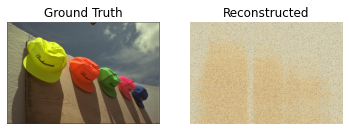

Epoch: 10 | Total Loss: 0.00086 | PSNR: 30.6658


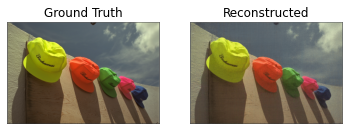

Epoch: 20 | Total Loss: 0.00056 | PSNR: 32.5550


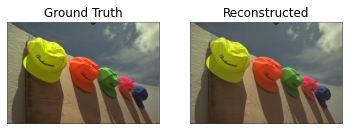

Epoch: 30 | Total Loss: 0.00042 | PSNR: 33.7194


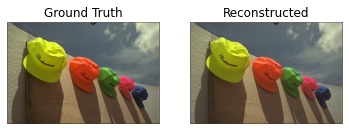

Epoch: 40 | Total Loss: 0.00035 | PSNR: 34.5514


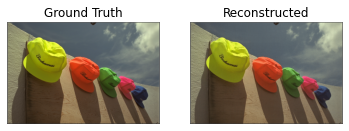

Epoch: 50 | Total Loss: 0.00030 | PSNR: 35.2925


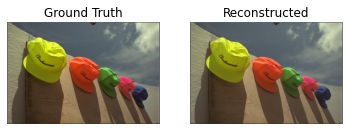

Epoch: 60 | Total Loss: 0.00026 | PSNR: 35.8391


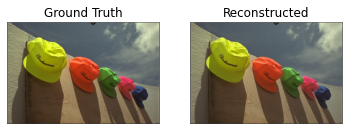

Epoch: 70 | Total Loss: 0.00024 | PSNR: 36.1309


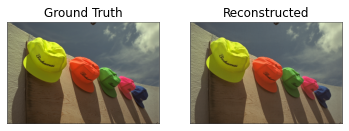

Epoch: 80 | Total Loss: 0.00021 | PSNR: 36.7348


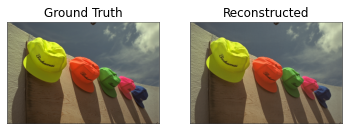

Epoch: 90 | Total Loss: 0.00019 | PSNR: 37.2169


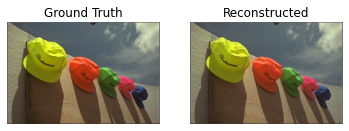

Epoch: 100 | Total Loss: 0.00017 | PSNR: 37.7401


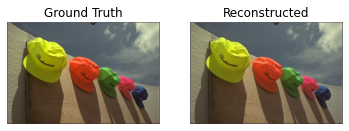

Epoch: 110 | Total Loss: 0.00015 | PSNR: 38.1386


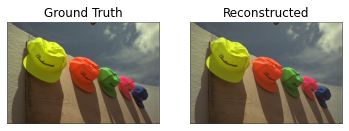

Epoch: 120 | Total Loss: 0.00014 | PSNR: 38.4509


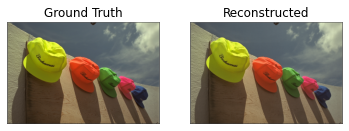

Epoch: 130 | Total Loss: 0.00013 | PSNR: 38.8187


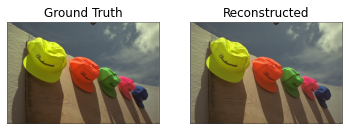

Epoch: 140 | Total Loss: 0.00013 | PSNR: 38.8922


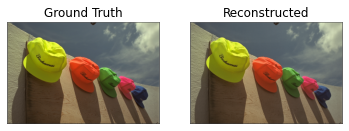

Epoch: 150 | Total Loss: 0.00011 | PSNR: 39.4134


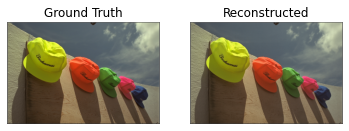

Epoch: 160 | Total Loss: 0.00011 | PSNR: 39.7458


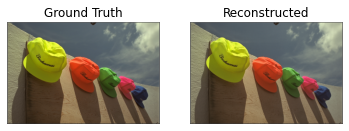

Epoch: 170 | Total Loss: 0.00011 | PSNR: 39.4504


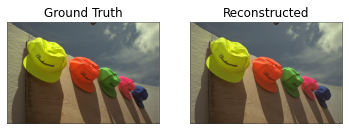

Epoch: 180 | Total Loss: 0.00010 | PSNR: 40.1623


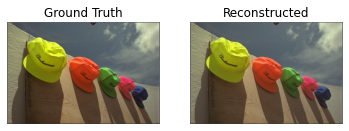

Epoch: 190 | Total Loss: 0.00009 | PSNR: 40.2944


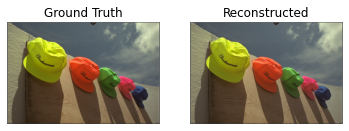

Epoch: 200 | Total Loss: 0.00009 | PSNR: 40.3467


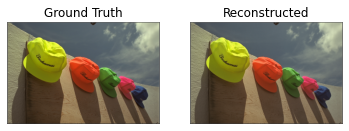

Epoch: 210 | Total Loss: 0.00008 | PSNR: 40.7640


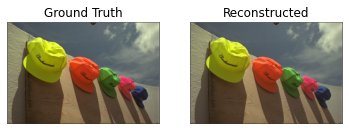

Epoch: 220 | Total Loss: 0.00008 | PSNR: 40.9274


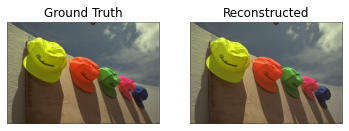

Epoch: 230 | Total Loss: 0.00008 | PSNR: 41.1039


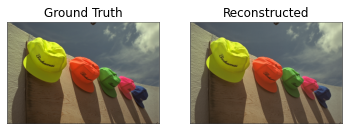

Epoch: 240 | Total Loss: 0.00008 | PSNR: 41.1832


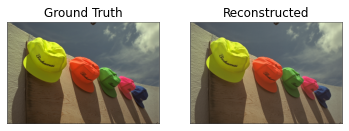

Epoch: 250 | Total Loss: 0.00007 | PSNR: 41.5036


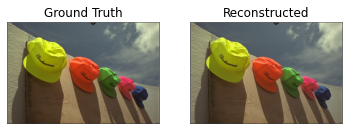

Epoch: 260 | Total Loss: 0.00007 | PSNR: 41.6486


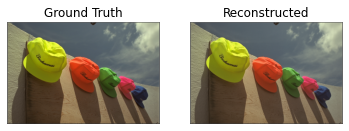

Epoch: 270 | Total Loss: 0.00007 | PSNR: 41.6370


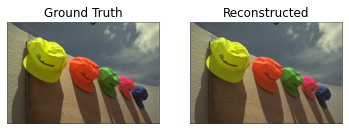

Epoch: 280 | Total Loss: 0.00006 | PSNR: 41.8960


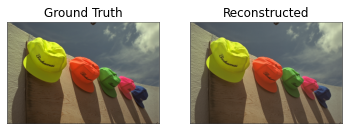

Epoch: 290 | Total Loss: 0.00006 | PSNR: 42.0524


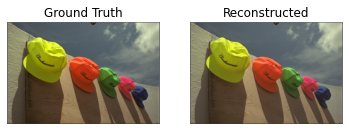

Epoch: 300 | Total Loss: 0.00006 | PSNR: 42.1875


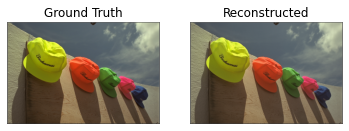

Epoch: 310 | Total Loss: 0.00006 | PSNR: 42.2316


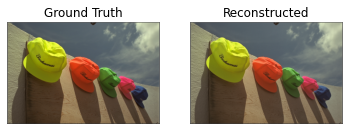

Epoch: 320 | Total Loss: 0.00006 | PSNR: 42.4722


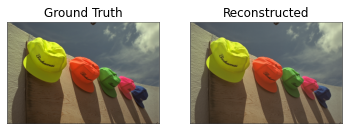

Epoch: 330 | Total Loss: 0.00006 | PSNR: 42.4777


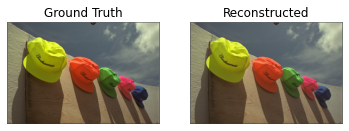

Epoch: 340 | Total Loss: 0.00005 | PSNR: 42.6911


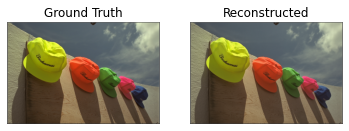

Epoch: 350 | Total Loss: 0.00005 | PSNR: 42.7902


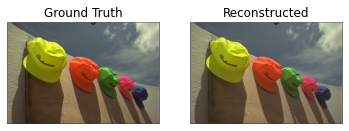

Epoch: 360 | Total Loss: 0.00005 | PSNR: 42.8668


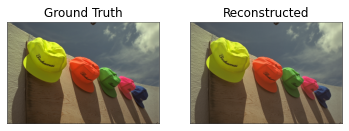

Epoch: 370 | Total Loss: 0.00005 | PSNR: 42.9802


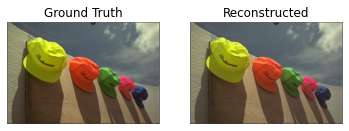

Epoch: 380 | Total Loss: 0.00005 | PSNR: 43.0512


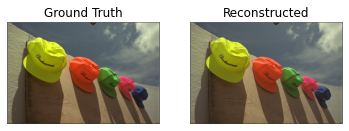

Epoch: 390 | Total Loss: 0.00005 | PSNR: 43.1280


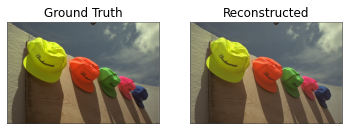

Epoch: 400 | Total Loss: 0.00005 | PSNR: 43.2123


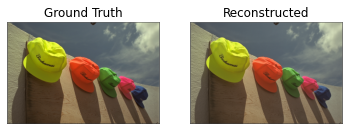

Epoch: 410 | Total Loss: 0.00005 | PSNR: 43.2787


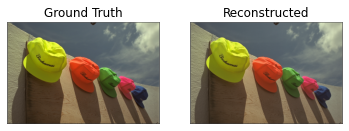

Epoch: 420 | Total Loss: 0.00005 | PSNR: 43.3551


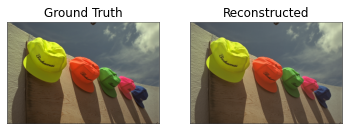

Epoch: 430 | Total Loss: 0.00005 | PSNR: 43.4339


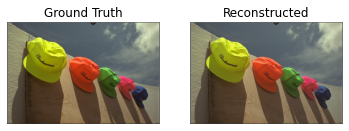

Epoch: 440 | Total Loss: 0.00004 | PSNR: 43.4906


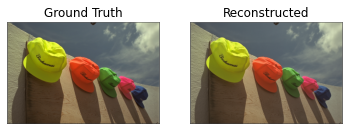

Epoch: 450 | Total Loss: 0.00004 | PSNR: 43.5651


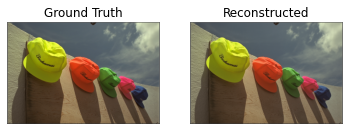

Epoch: 460 | Total Loss: 0.00004 | PSNR: 43.6092


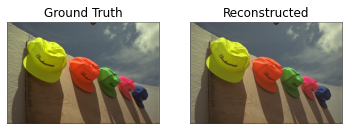

Epoch: 470 | Total Loss: 0.00004 | PSNR: 43.6432


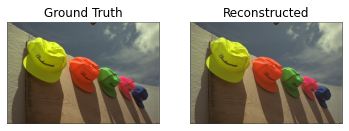

Epoch: 480 | Total Loss: 0.00004 | PSNR: 43.7639


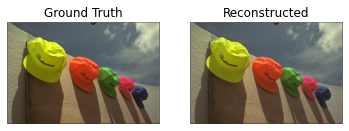

Epoch: 490 | Total Loss: 0.00004 | PSNR: 43.8056


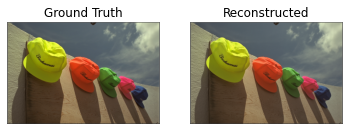

--------------------
Max PSNR: 43.85652160644531
--------------------


In [155]:
args.steps_til_summary = 10
degree =2
hidden = 256

# with multiplication
args.inr_model = 'kan'
#KAN ***************
# im = normalize(plt.imread(args.input).astype(np.float32), True)
# im = cv2.resize(im, (512, 512), interpolation=cv2.INTER_AREA)
# im = gaussian_pyramid[0]
H, W, _ = im.shape
args.steps_til_summary = 10

args.niters = 500

args.using_schedular = True

def find_tiles(b_indices, H, W, grid_size=16):
  row_indices = b_indices // W
  col_indices = b_indices % W

  tile_row_indices = row_indices // grid_size
  tile_col_indices = col_indices // grid_size

  return tile_row_indices, tile_col_indices


# im = utils.normalize(sorted_grids[0, 0].astype(np.float32), True)
# # im = cv2.resize(im, None, fx=1/4, fy=1/4, interpolation=cv2.INTER_AREA)



# im = utils.normalize(gaussian_pyramid[0].astype(np.float32), True)
# # im = cv2.resize(im, None, fx=1/4, fy=1/4, interpolation=cv2.INTER_AREA)
# H, W, _ = im.shape

# H, W, _ = im.shape

# Optimizer setup
if args.inr_model == 'wire':
    args.lr = args.lr * min(1, args.maxpoints / (H * W))
optim = torch.optim.Adam(lr=args.lr, params=model.parameters())
scheduler = lr_scheduler.LambdaLR(optim, lambda x: args.scheduler_b ** min(x / args.niters, 1))
#scheduler=torch.optim.lr_scheduler.MultiStepLR(optimizer=optim,
#        milestones=[0.5 * args.niters,0.75 * args.niters, 0.9 * args.niters],gamma=0.1)

# Initialize lists for PSNR and MSE values
psnr_values = []
mse_array = torch.zeros(args.niters, device=device)

# Initialize best loss value as positive infinity
best_loss = torch.tensor(float('inf'))

# Generate coordinate grid
coords = utils.get_coords(H, W, dim=2)[None, ...]

# # Create a new tensor with the scalar value 7.0
# new_value = torch.tensor([6.0])

# # Expand 'new_value' to match the size of 'coords' along the last dimension
# new_value_expanded = new_value.unsqueeze(0).unsqueeze(1).expand_as(coords[..., :1])


# # Concatenate 'coords' and 'new_value_expanded' along the last dimension
# coords = torch.cat((coords, new_value_expanded), dim=-1)

# Convert input image to a tensor and reshape
gt = torch.tensor(im).reshape(H * W, 3)[None, ...].to(device)

# Initialize a tensor for reconstructed data
rec = torch.zeros_like(gt)

for step in tqdm(range(args.niters)):
    # Randomize the order of data points for each iteration
    indices = torch.randperm(H*W)

    # Process data points in batches
    for b_idx in range(0, H*W, args.maxpoints):
        b_indices = indices[b_idx:min(H*W, b_idx+args.maxpoints)]

        b_coords = coords[:, b_indices, ...].to(device)
        b_indices = b_indices.to(device)


        # Calculate model output
        if args.inr_model == 'ab':
            model_output, coef = model(b_coords)
        else:
            # tile_row_indices, tile_col_indices = find_tiles(b_indices, H, W)
            # b_tiles = tiles[tile_row_indices, tile_col_indices, ...].to(device)
            model_output = model(b_coords.squeeze(0))
            model_output = model_output.unsqueeze(0)

        # Update the reconstructed data
        with torch.no_grad():
            rec[:, b_indices, :] = model_output

        # Calculate the output loss
        output_loss = ((model_output - gt[:, b_indices, :])**2).mean()

        if args.inr_model == 'ab':
       
            a_coef, b_coef, c_coef, d_coef = coef[0]
            reg_loss = args.a_coef * torch.relu(-a_coef) + \
                       args.b_coef * torch.relu(-b_coef) + \
                       args.c_coef * torch.relu(-c_coef) + \
                       args.d_coef * torch.relu(-d_coef)

            
            loss = output_loss + reg_loss
        else:
            # Total loss for other models
            loss = output_loss

        # Perform backpropagation and update model parameters
        optim.zero_grad()
        loss.backward()
        optim.step()

    # Calculate PSNR
    with torch.no_grad():
        mse_array[step] = ((gt - rec)**2).mean().item()
        psnr = -10*torch.log10(mse_array[step])
        psnr_values.append(psnr.item())

    # Adjust learning rate using a scheduler if applicable
    if args.using_schedular:
        if args.inr_model == 'kan' and step > 30:
            scheduler.step()
        else:
            scheduler.step()

    # Prepare reconstructed image for visualization
    imrec = rec[0, ...].reshape(H, W, 3).detach().cpu().numpy()

    # Check if the current iteration's loss is the best so far
    if (mse_array[step] < best_loss) or (step == 0):
        best_loss = mse_array[step]
        best_img = imrec
        best_img = (best_img - best_img.min()) / (best_img.max() - best_img.min())

    # Display intermediate results at specified intervals
    if step % args.steps_til_summary == 0:
        print("Epoch: {} | Total Loss: {:.5f} | PSNR: {:.4f}".format(step,
                                                                     mse_array[step].item(),
                                                                     psnr.item()))

        # Plot
        fig, axes = plt.subplots(1, 2, figsize=(6, 6))
        axes[0].set_title('Ground Truth')
        axes[0].imshow(im)
        axes[0].axis('off')
        axes[1].set_title('Reconstructed')
        axes[1].imshow(best_img)
        axes[1].axis('off')
        plt.show()


# Print maximum PSNR achieved during training
print('--------------------')
print('Max PSNR:', max(psnr_values))
print('--------------------')


# del psnr_values[:]

In [156]:
## plot psnr
## psnr and ssim



# Load the images
with open('kats-psnr.txt', 'w') as file:
    for item in psnr_values:
        file.write(f"{item}\n")




import torchmetrics


sim = torchmetrics.StructuralSimilarityIndexMeasure()

bbi = torch.tensor(best_img).permute(2, 0, 1).unsqueeze(0)
imgg = torch.tensor(im).permute(2, 0, 1).unsqueeze(0)

ssim_index = sim(bbi,imgg)

# Ensure the images have the same dimensions

# Compute SSIM


/home/moein/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


In [142]:
ssim_index

tensor(0.9726)